# Домашнее задание по машинному обучению 2023
# Богомольная Екатерина гр. 5030103/00201

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

## Работа с данными

In [2]:
df = pl.read_json('data.json')
print(df)

shape: (39_774, 3)
┌───────┬─────────────┬───────────────────────────────────┐
│ id    ┆ cuisine     ┆ ingredients                       │
│ ---   ┆ ---         ┆ ---                               │
│ i64   ┆ str         ┆ list[str]                         │
╞═══════╪═════════════╪═══════════════════════════════════╡
│ 10259 ┆ greek       ┆ ["romaine lettuce", "black olive… │
│ 25693 ┆ southern_us ┆ ["plain flour", "ground pepper",… │
│ 20130 ┆ filipino    ┆ ["eggs", "pepper", … "chicken li… │
│ 22213 ┆ indian      ┆ ["water", "vegetable oil", … "sa… │
│ 13162 ┆ indian      ┆ ["black pepper", "shallots", … "… │
│ …     ┆ …           ┆ …                                 │
│ 29109 ┆ irish       ┆ ["light brown sugar", "granulate… │
│ 11462 ┆ italian     ┆ ["KRAFT Zesty Italian Dressing",… │
│ 2238  ┆ irish       ┆ ["eggs", "citrus fruit", … "butt… │
│ 41882 ┆ chinese     ┆ ["boneless chicken skinless thig… │
│ 2362  ┆ mexican     ┆ ["green chile", "jalapeno chilie… │
└───────┴────────────

Из датафрейма выше видно, что первая колонка id имеет тип int64 (не несёт информации для обучения модели), cuisine имеет тип str (переменная которую будем предсказывать), ingredients содержит информацию о ингредиентах в блюдах, по которым нужно будет обучить модель, но данная колонка имеет тип list[str] и не подходит для обучения.

Можно расписать последний столбец следующим способом, добавить все ингредиенты в один список, оставить в нём только уникальные ингредиенты. Дальше создать столбцы в dataframe с названием колонок из списка, а потом для каждого блюда ставить в ячейке (пересечение строки и столбца с названием ингредиента) 1 если ингредиент есть в блюде, и 0 если нет. После такой аналогии one hot encoding можно будет проанализировать данные и обучать модель.

In [3]:
df["cuisine"].n_unique()

20

Всего 20 уникальных значений в колонке cuisine. То есть это задача классификации на 20 классов.

In [4]:
all_ingredients = []
for row in range(df.shape[0]):
    all_ingredients.extend(list(df[row, "ingredients"]))
all_ingredients = list(set(all_ingredients))

Получили все уникальные ингредиенты, теперь можно создать колонки.

In [5]:
ingredient = pl.DataFrame(data=np.zeros((df.shape[0], len(all_ingredients))).astype(int), schema=all_ingredients)

In [6]:
print(ingredient)

shape: (39_774, 6_714)
┌──────────────────────────┬──────────┬───────────────┬──────────┬───┬───────────────┬─────────┬────────────┬──────────┐
│ Nielsen-Massey Vanilla   ┆ ground   ┆ fudge brownie ┆ bechamel ┆ … ┆ proscuitto di ┆ chicken ┆ gingersnap ┆ crackers │
│ Extract                  ┆ blanched ┆ mix           ┆ ---      ┆   ┆ parma         ┆ fillets ┆ crumbs     ┆ ---      │
│ ---                      ┆ almonds  ┆ ---           ┆ i32      ┆   ┆ ---           ┆ ---     ┆ ---        ┆ i32      │
│ i32                      ┆ ---      ┆ i32           ┆          ┆   ┆ i32           ┆ i32     ┆ i32        ┆          │
│                          ┆ i32      ┆               ┆          ┆   ┆               ┆         ┆            ┆          │
╞══════════════════════════╪══════════╪═══════════════╪══════════╪═══╪═══════════════╪═════════╪════════════╪══════════╡
│ 0                        ┆ 0        ┆ 0             ┆ 0        ┆ … ┆ 0             ┆ 0       ┆ 0          ┆ 0        │
│ 0      

In [7]:
df = pl.concat([df, ingredient], how="horizontal")

In [8]:
print(df)

shape: (39_774, 6_717)
┌───────┬─────────────┬────────────────────────┬─────────────────┬───┬───────────────┬─────────┬────────────┬──────────┐
│ id    ┆ cuisine     ┆ ingredients            ┆ Nielsen-Massey  ┆ … ┆ proscuitto di ┆ chicken ┆ gingersnap ┆ crackers │
│ ---   ┆ ---         ┆ ---                    ┆ Vanilla Extract ┆   ┆ parma         ┆ fillets ┆ crumbs     ┆ ---      │
│ i64   ┆ str         ┆ list[str]              ┆ ---             ┆   ┆ ---           ┆ ---     ┆ ---        ┆ i32      │
│       ┆             ┆                        ┆ i32             ┆   ┆ i32           ┆ i32     ┆ i32        ┆          │
╞═══════╪═════════════╪════════════════════════╪═════════════════╪═══╪═══════════════╪═════════╪════════════╪══════════╡
│ 10259 ┆ greek       ┆ ["romaine lettuce",    ┆ 0               ┆ … ┆ 0             ┆ 0       ┆ 0          ┆ 0        │
│       ┆             ┆ "black olive…          ┆                 ┆   ┆               ┆         ┆            ┆          │
│ 25693 ┆

In [9]:
del ingredient

Теперь можно сделать one hot encoding

In [10]:
for row in range(df.shape[0]):
    for ingredient in df[row, "ingredients"]:
        df[row, ingredient] = 1    

In [11]:
print(df)

shape: (39_774, 6_717)
┌───────┬─────────────┬────────────────────────┬─────────────────┬───┬───────────────┬─────────┬────────────┬──────────┐
│ id    ┆ cuisine     ┆ ingredients            ┆ Nielsen-Massey  ┆ … ┆ proscuitto di ┆ chicken ┆ gingersnap ┆ crackers │
│ ---   ┆ ---         ┆ ---                    ┆ Vanilla Extract ┆   ┆ parma         ┆ fillets ┆ crumbs     ┆ ---      │
│ i64   ┆ str         ┆ list[str]              ┆ ---             ┆   ┆ ---           ┆ ---     ┆ ---        ┆ i32      │
│       ┆             ┆                        ┆ i32             ┆   ┆ i32           ┆ i32     ┆ i32        ┆          │
╞═══════╪═════════════╪════════════════════════╪═════════════════╪═══╪═══════════════╪═════════╪════════════╪══════════╡
│ 10259 ┆ greek       ┆ ["romaine lettuce",    ┆ 0               ┆ … ┆ 0             ┆ 0       ┆ 0          ┆ 0        │
│       ┆             ┆ "black olive…          ┆                 ┆   ┆               ┆         ┆            ┆          │
│ 25693 ┆

Дропнем колонки id & ingredients. id не несёт в себе смысла кроме номера блюда, а ingredients были декодированы с помощью one hot encoding.

In [12]:
df = df.drop(["id", "ingredients"])

In [13]:
print(df)

shape: (39_774, 6_715)
┌─────────────┬──────────────────┬──────────┬──────────────────┬───┬─────────────────┬─────────┬────────────┬──────────┐
│ cuisine     ┆ Nielsen-Massey   ┆ ground   ┆ fudge brownie    ┆ … ┆ proscuitto di   ┆ chicken ┆ gingersnap ┆ crackers │
│ ---         ┆ Vanilla Extract  ┆ blanched ┆ mix              ┆   ┆ parma           ┆ fillets ┆ crumbs     ┆ ---      │
│ str         ┆ ---              ┆ almonds  ┆ ---              ┆   ┆ ---             ┆ ---     ┆ ---        ┆ i32      │
│             ┆ i32              ┆ ---      ┆ i32              ┆   ┆ i32             ┆ i32     ┆ i32        ┆          │
│             ┆                  ┆ i32      ┆                  ┆   ┆                 ┆         ┆            ┆          │
╞═════════════╪══════════════════╪══════════╪══════════════════╪═══╪═════════════════╪═════════╪════════════╪══════════╡
│ greek       ┆ 0                ┆ 0        ┆ 0                ┆ … ┆ 0               ┆ 0       ┆ 0          ┆ 0        │
│ souther

Теперь данные имеют такой вид, что по ним можно провести анализ и обучить модель.

## Анализ данных 

Для начала найдём 10 самых часто встречающихся игнредиентов.

In [14]:
ingredient = df.drop('cuisine').sum()\
    .transpose(include_header=True)\
    .rename({"column": "ingredient", "column_0": "count"})\
    .sort("count", descending=True)\
    .head(10)

In [15]:
print(ingredient)

shape: (10, 2)
┌─────────────────────┬───────┐
│ ingredient          ┆ count │
│ ---                 ┆ ---   │
│ str                 ┆ i32   │
╞═════════════════════╪═══════╡
│ salt                ┆ 18048 │
│ onions              ┆ 7972  │
│ olive oil           ┆ 7971  │
│ water               ┆ 7457  │
│ garlic              ┆ 7380  │
│ sugar               ┆ 6434  │
│ garlic cloves       ┆ 6236  │
│ butter              ┆ 4847  │
│ ground black pepper ┆ 4784  │
│ all-purpose flour   ┆ 4632  │
└─────────────────────┴───────┘


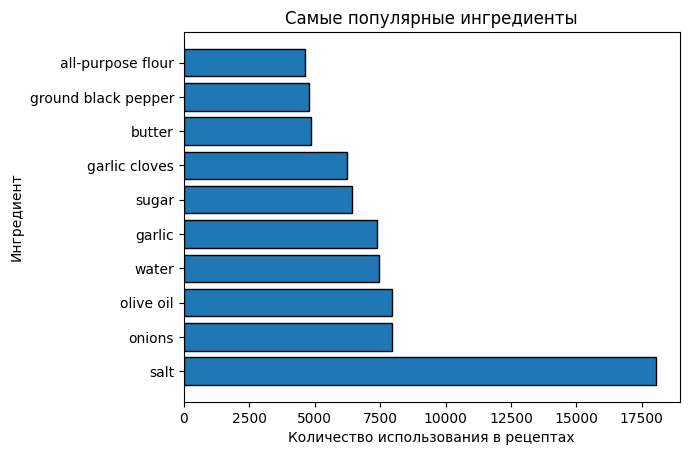

In [16]:
plt.barh(ingredient['ingredient'], ingredient['count'], edgecolor='black')
plt.xlabel('Количество использования в рецептах')
plt.ylabel('Ингредиент')
plt.title('Самые популярные ингредиенты')
plt.show()

Также посмотрим самые популярные ингредиенты для каждой кухни, это можно сделать аналогичным образом, только указав нужную кухню для выбора.

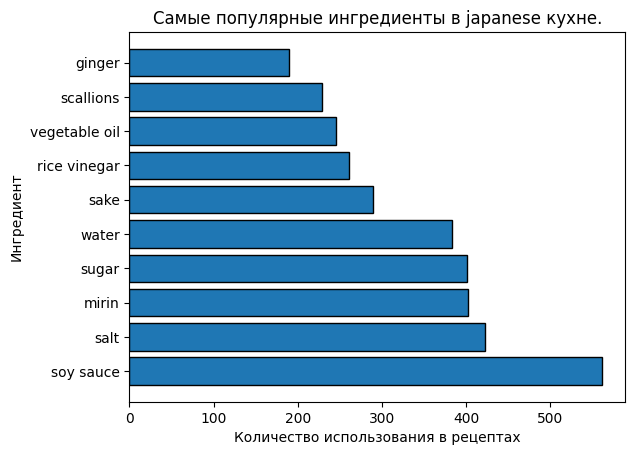

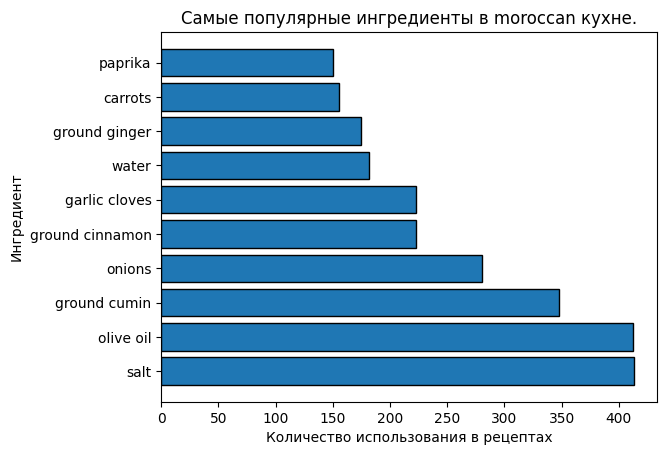

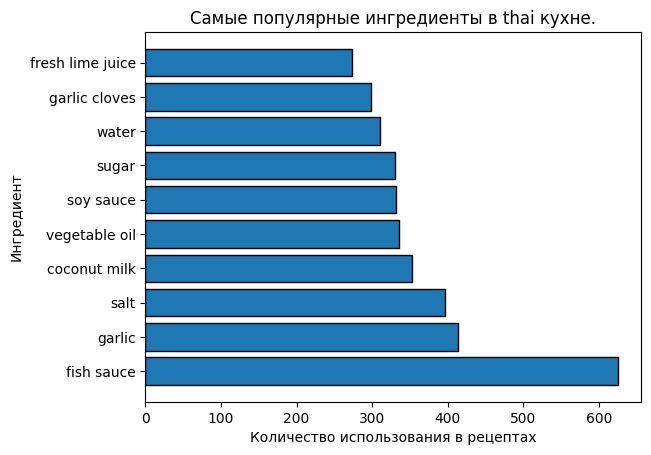

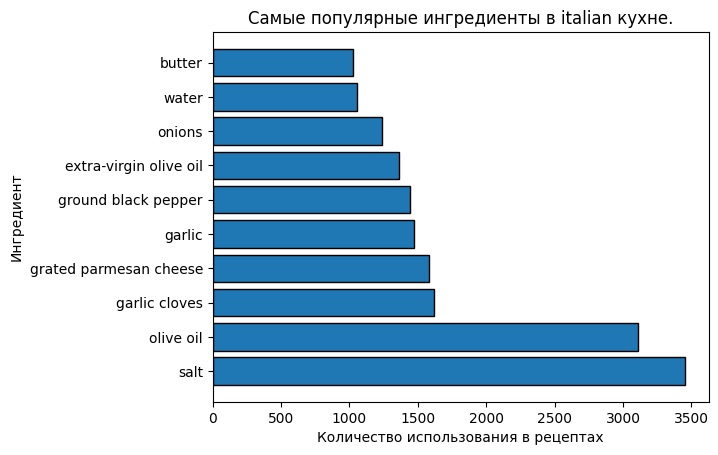

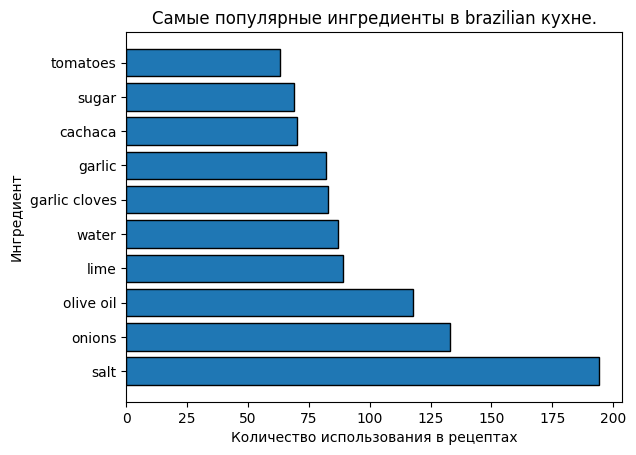

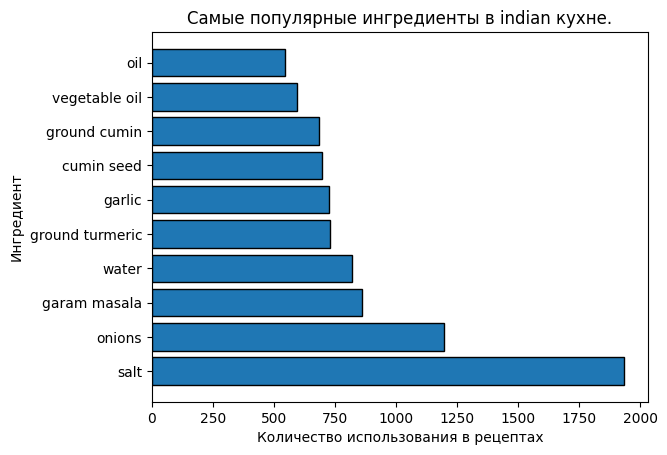

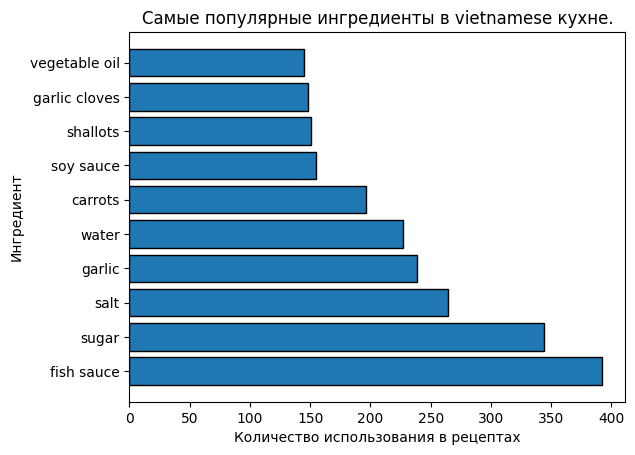

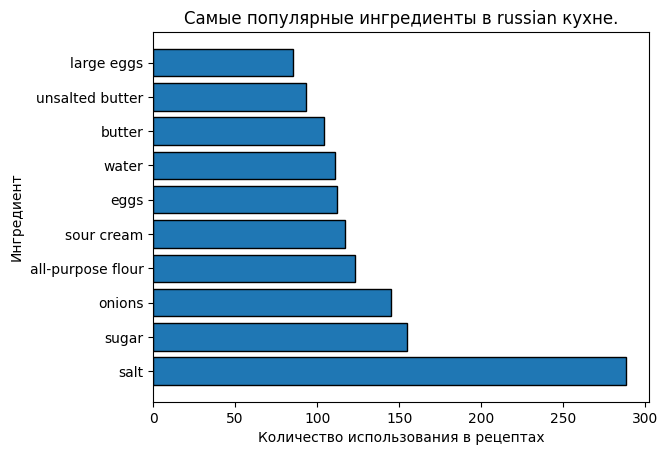

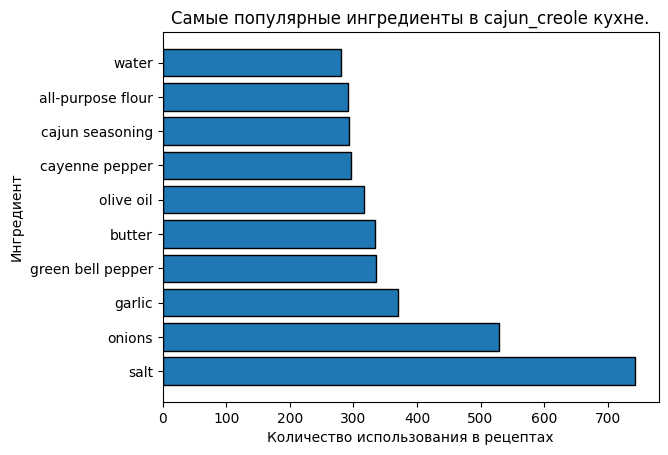

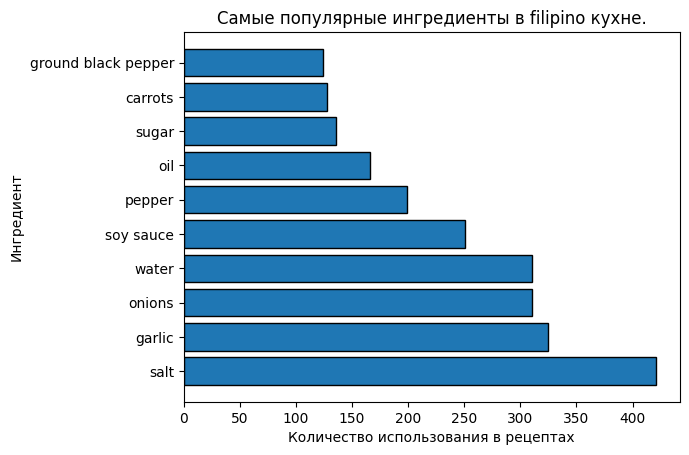

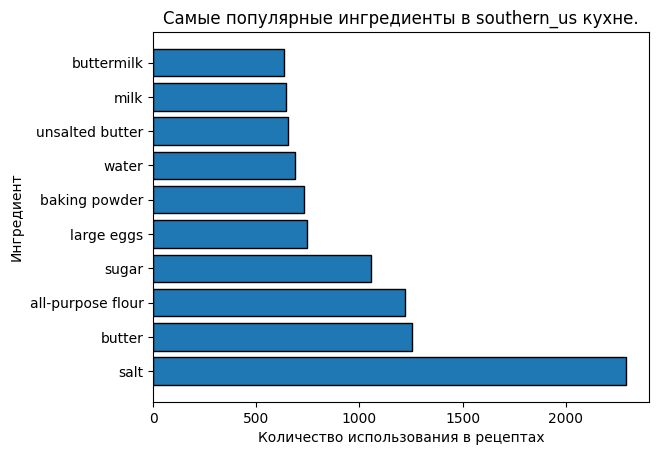

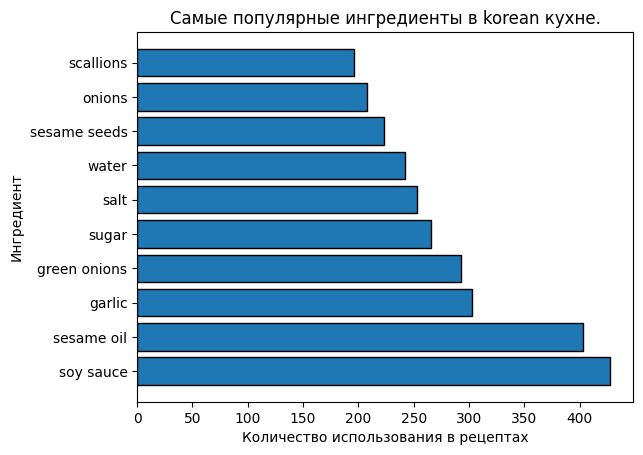

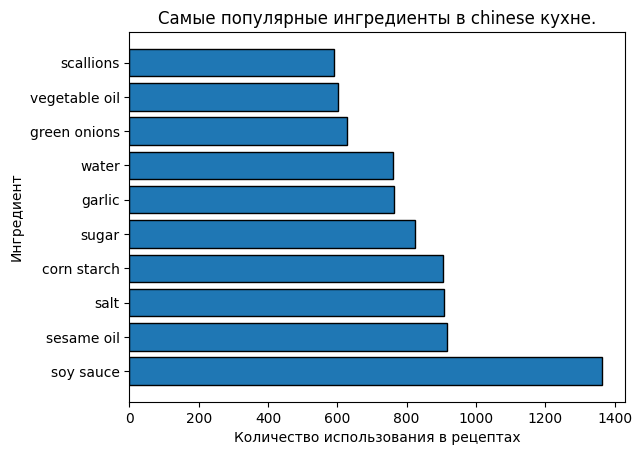

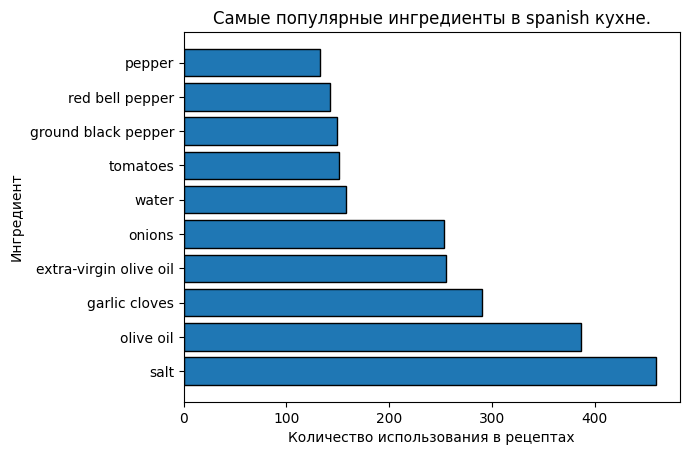

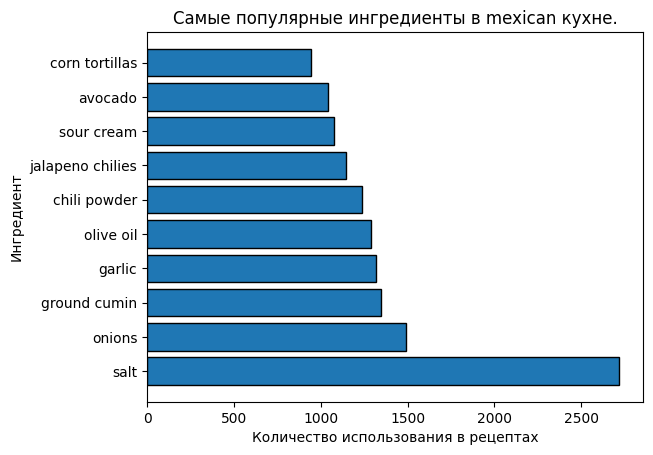

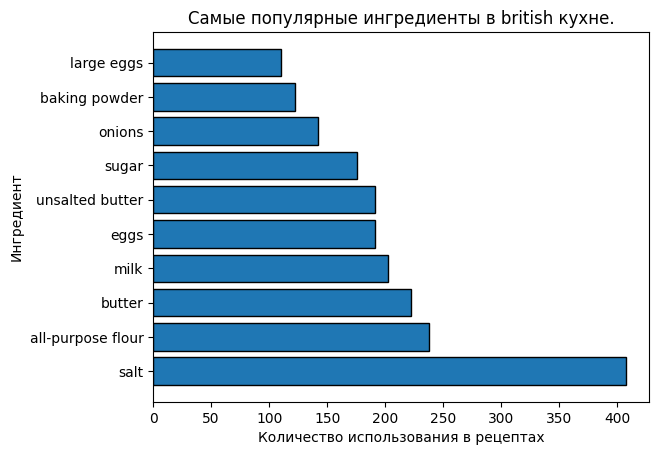

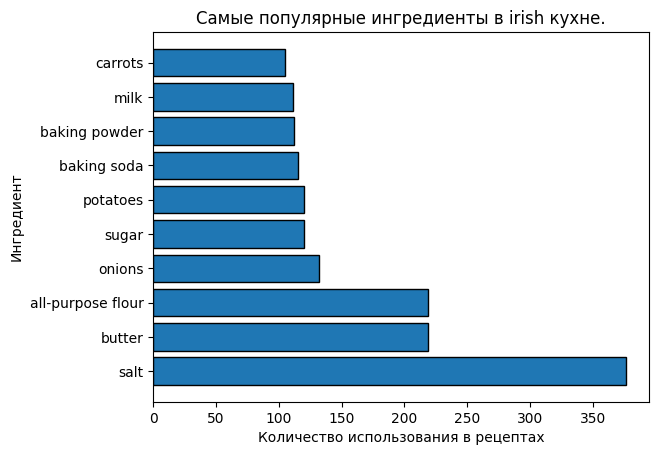

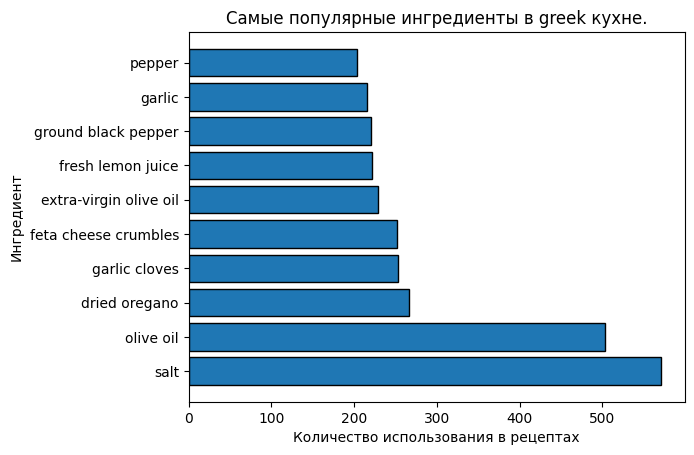

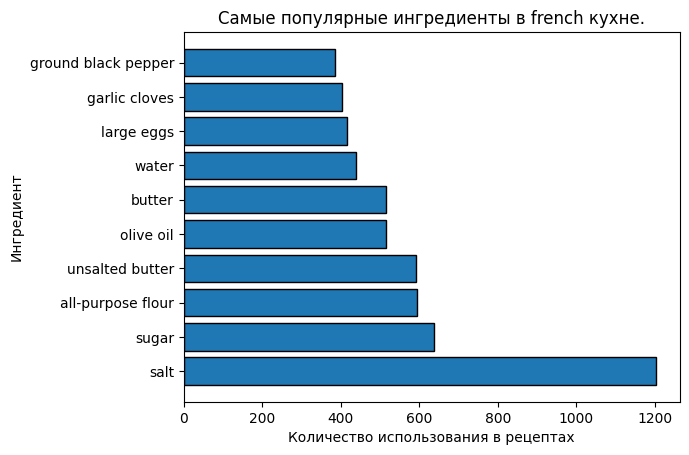

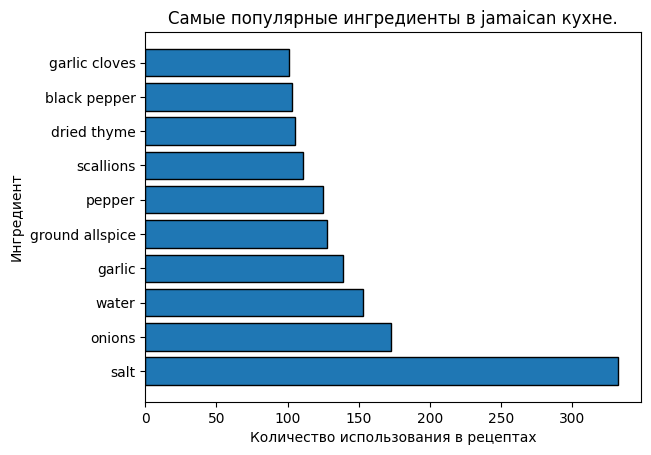

In [17]:
for cuisine in list(df["cuisine"].unique()):
    ingredient = df.filter(pl.col("cuisine") == cuisine).drop("cuisine").sum()\
        .transpose(include_header=True)\
        .rename({"column": "ingredient", "column_0": "count"})\
        .sort("count", descending=True)\
        .head(10)
    plt.barh(ingredient["ingredient"], ingredient["count"], edgecolor="black")
    plt.xlabel("Количество использования в рецептах")
    plt.ylabel("Ингредиент")
    plt.title(f"Самые популярные ингредиенты в {cuisine} кухне.")
    plt.show()

Также не будет лишним посмотреть на распределение таргета.

In [18]:
ingredient = df["cuisine"].value_counts().sort("count", descending=True)
print(ingredient)

shape: (20, 2)
┌─────────────┬───────┐
│ cuisine     ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ italian     ┆ 7838  │
│ mexican     ┆ 6438  │
│ southern_us ┆ 4320  │
│ indian      ┆ 3003  │
│ chinese     ┆ 2673  │
│ …           ┆ …     │
│ filipino    ┆ 755   │
│ irish       ┆ 667   │
│ jamaican    ┆ 526   │
│ russian     ┆ 489   │
│ brazilian   ┆ 467   │
└─────────────┴───────┘


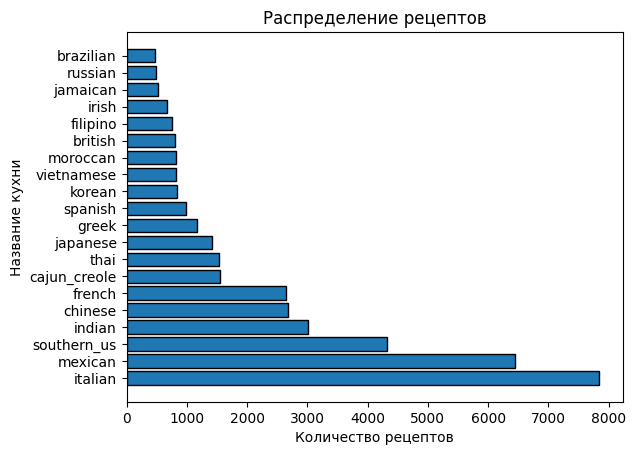

In [19]:
plt.barh(ingredient['cuisine'], ingredient['count'], edgecolor='black')
plt.xlabel('Количество рецептов')
plt.ylabel('Название кухни')
plt.title('Распределение рецептов')
plt.show()

Распределение рецептов отличается от равномерного (видно из диаграммы).\
Это нужно будет учесть при формировании train & test выборки.

## Создание train & test выборки. 

In [20]:
features = df.drop("cuisine")

In [21]:
print(features)

shape: (39_774, 6_714)
┌──────────────────────────┬──────────┬───────────────┬──────────┬───┬───────────────┬─────────┬────────────┬──────────┐
│ Nielsen-Massey Vanilla   ┆ ground   ┆ fudge brownie ┆ bechamel ┆ … ┆ proscuitto di ┆ chicken ┆ gingersnap ┆ crackers │
│ Extract                  ┆ blanched ┆ mix           ┆ ---      ┆   ┆ parma         ┆ fillets ┆ crumbs     ┆ ---      │
│ ---                      ┆ almonds  ┆ ---           ┆ i32      ┆   ┆ ---           ┆ ---     ┆ ---        ┆ i32      │
│ i32                      ┆ ---      ┆ i32           ┆          ┆   ┆ i32           ┆ i32     ┆ i32        ┆          │
│                          ┆ i32      ┆               ┆          ┆   ┆               ┆         ┆            ┆          │
╞══════════════════════════╪══════════╪═══════════════╪══════════╪═══╪═══════════════╪═════════╪════════════╪══════════╡
│ 0                        ┆ 0        ┆ 0             ┆ 0        ┆ … ┆ 0             ┆ 0       ┆ 0          ┆ 0        │
│ 0      

In [22]:
target = df["cuisine"]

In [23]:
print(target)

shape: (39_774,)
Series: 'cuisine' [str]
[
	"greek"
	"southern_us"
	"filipino"
	"indian"
	"indian"
	"jamaican"
	"spanish"
	"italian"
	"mexican"
	"italian"
	"italian"
	"chinese"
	…
	"chinese"
	"indian"
	"italian"
	"mexican"
	"indian"
	"irish"
	"italian"
	"mexican"
	"irish"
	"italian"
	"irish"
	"chinese"
	"mexican"
]


In [24]:
f_train, f_test, target_train, target_test = train_test_split(features, target,
                                                              test_size=0.33, random_state=5619, stratify=target)

## Обучение моделей. 

В качестве первой модели попробуем логистическую регрессию.

In [25]:
linear_classifier = LogisticRegression(n_jobs=-1)
linear_classifier.fit(f_train, target_train)
score = accuracy_score(target_test, linear_classifier.predict(f_test))

In [26]:
print(f"Логистическая регрессия: accuracy score = {score}")

Логистическая регрессия: accuracy score = 0.7722840164558891


Можно попробовать метод опорных векторов.

In [27]:
svm = SVC(kernel="linear")
svm.fit(f_train, target_train)
score = accuracy_score(target_test, svm.predict(f_test))

In [28]:
print(f"Метод опорных векторов с линейным ядром: accuracy score = {score}")

Метод опорных векторов с линейным ядром: accuracy score = 0.7461526740819747


В лекциях был метод k ближайших соседей.

In [29]:
knn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
knn.fit(f_train.to_numpy(), target_train)
score = accuracy_score(target_test, knn.predict(f_test.to_numpy()))

In [30]:
print(f"Метод K ближайших соседей: accuracy score = {score}")

Метод K ближайших соседей: accuracy score = 0.5065518817613897


В лекциях был метод градиентного бустинга.

In [45]:
clf = LGBMClassifier(n_estimators=100)
clf.fit(f_train.to_numpy(), target_train)
score = accuracy_score(target_test, clf.predict(f_test.to_numpy()))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 26648, number of used features: 1370
[LightGBM] [Info] Start training from score -4.444266
[LightGBM] [Info] Start training from score -3.900754
[LightGBM] [Info] Start training from score -3.247347
[LightGBM] [Info] Start training from score -2.699940
[LightGBM] [Info] Start training from score -3.963933
[LightGBM] [Info] Start training from score -2.710041
[LightGBM] [Info] Start training from score -3.522241
[LightGBM] [Info] Start training from score -2.583585
[LightGBM] [Info] Start training from score -4.087911
[LightGBM] [Info] Start training from score -1.624296
[LightGBM] [Info] Start training from score -4.326838
[LightGBM] [Info] Start training from score -3.3308

In [54]:
print(f"Метод градиентного бустинга: accuracy score = {score}")

Метод градиентного бустинга: accuracy score = 0.7610086850525675


## Заключение 

В данном проекте были обработаны данные и обучены 4 модели машинного обучения.\
Логистическая регрессия: accuracy score = 0.7722840164558891\
Метод опорных векторов с линейным ядром: accuracy score = 0.7461526740819747\
Метод K ближайших соседей: accuracy score = 0.5065518817613897
Метод градиентного бустинга: accuracy score = 0.7610086850525675

Самый лучший результат был получен с помощью модели логистическо регрессии, а худший результат был получен методом k ближайших соседей.